# Pretraining with stacked autoencoders (2)
Assignment 2 **Task 3** | Notebook by **Group 19**

In this notebook, we will perform autoencoder based dimensionality reduction on image data (no features extracted). The modus operandi stays similar to the previous task, except for the part where data is loaded into the environment.

In [3]:
# Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import transforms

%matplotlib notebook

## Data Loaders
In this section, we define functions to load all images and labels into lists from disk (as csv files), and to generate dataloaders compatible with PyTorch models. 

In [4]:
# Data collector

def generate_data(root_path):
    
    all_data, labels = [], []
    
    for f in tqdm(os.listdir(root_path)):
        data = pd.read_csv(root_path + '/' + f, header=None)
        all_data.extend(data.values)
        labels.extend([f]*len(data))
        
    all_data, labels = np.array(all_data), np.array(labels)
    
    # Label encode
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    
    return all_data, labels


# Data loader generator

def get_data_loaders(features, target, batch_size=500, test_split=0.2):
    
    if test_split is not None:
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_split, shuffle=True)
        X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
        y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

        d_train = torch.utils.data.TensorDataset(X_train, y_train)
        d_test = torch.utils.data.TensorDataset(X_test, y_test)

        train_loader = torch.utils.data.DataLoader(d_train, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(d_test, batch_size=batch_size, shuffle=True)
        
        return train_loader, test_loader
    
    else:
        X, y = torch.from_numpy(features), torch.from_numpy(target)
        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        return loader


# Process images

def process_images(data):
    
    """Not needed for the purpose of this task
       Reshapes images from (1, 784) --> (1, 28, 28)
       Don't know why I wrote this function"""
    
    images = []
    
    for i in data:
        images.extend(i.reshape(1, 28, 28))
        
    return np.asarray(images).reshape(-1, 1, 28, 28)


# Get data
all_data, labels = generate_data(root_path='../data/data2')
all_images = process_images(all_data)

100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


## Visualization
In this section, we reduce the dimensionality of the data and transform it using t-SNE to observe their spatial orientation. Through this, we will get an idea of class separability and how good we can expect the models to perform. 

In [5]:
# TSNE reduction
tsne = TSNE(n_components=3)
data_tsne = tsne.fit_transform(all_data)
x, y, z = data_tsne[:, 0], data_tsne[:, 1], data_tsne[:, 2]

# Plot 
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color=labels)))
fig.update_layout(autosize=False, width=600, height=600, title='Dataset 2 TSNE plot')
fig.show()

## Runtime functions
Here we define functions for training and evaluation of the model's progress. First, we define functions for classifier networks with Nonlinear Logloss (NLL Loss). Then we define functions for regression networks with Mean Squared Error (MSE) Loss. These will be used for configuring encoder-decoder models. 

In [4]:
# Training function

def train_clf(model, train_loader, optimizer, epoch):
    # Set model in training mode
    model.train()  
    # List to store loss values for each batch
    loss_history = []
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Initialize optimizer
        optimizer.zero_grad()
        # Generate predictions using model
        output = model(data.float())
        # Compute loss (Nonlinear logloss)
        loss = F.nll_loss(output, target)
        # Append value of loss to loss_history list
        loss_history.append(loss.item())
        # Backpropagate loss to improve model parameters
        loss.backward()
        # Find number of correct predictions
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        # Update optimizer parameters
        optimizer.step()
    
    accuracy = 100*correct/len(train_loader.dataset)
    
    return np.array(loss_history).mean(), accuracy
        
    
# Test function

def test_clf(model, test_loader, epoch, log_freq=10):
    # Set model in evaluation mode
    # Model paramters do not change when in this state
    model.eval()
    # Counters for overall loss and correct classifications for test data
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Generate model predictions
            output = model(data.float())
            # Compute loss value (sum over all examples) and update test_loss 
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # Find prediction index
            pred = output.argmax(dim=1, keepdim=True)
            # Transform target into one-hot vector and find number of correct classifications
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Average test loss over test data
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct/len(test_loader.dataset)
    
    # Console ouptut
    if epoch % log_freq == 0:
        print("Test {} : Average loss: {:.4f} \t Accuracy: {}/{} ({:.2f}%)".format(
            epoch, test_loss, correct, len(test_loader.dataset), test_accuracy
        ))
        
    return test_loss, test_accuracy 

# ====================================================================================
# Train and test functions for regression networks
# These will be used to track reconstruction loss for encoder-decoder networks
# ====================================================================================

# Training function

def train_reg(model, train_loader, optimizer, epoch):
    # Set model in training mode (parameter updates valid)
    model.train()
    # List to store total loss for each batch
    loss_history = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Initialize optimizer
        optimizer.zero_grad()
        # Generate model predictions
        output = model(data.float())
        # Calculate MSE loss
        loss = F.mse_loss(output.float(), target.float())
        loss_history.append(loss.item())
        # Backpropagate loss
        loss.backward()
        # Update optimizer parameters
        optimizer.step()
    
    return np.array(loss_history).mean()
        
    
# Test function

def test_reg(model, test_loader, epoch, log_freq=10):
    # Set model in evaluation mode (no parameter updates)
    model.eval()
    # Loss counter for test data
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            # Generate model predictions
            output = model(data.float())
            # Compute MSE loss and update test_loss
            test_loss += F.mse_loss(output.float(), target.float(), reduction='mean').item()
            
    # Average test loss over test data
    test_loss /= len(test_loader.dataset)
    
    # Console output
    if epoch % log_freq == 0:
        print("Test {} : Average loss: {:.4f}".format(
            epoch, test_loss
        ))
        
    return test_loss

## Network definition
In this section we define the three AANNs that will be used for reducing the dataset's dimensions. The reductions in sizes are as follows (the first dimensions of each data point is 1).

$$
(784, 500)\quad => \quad (500, 300)\quad => \quad(300, 200)
$$

In [5]:
# Normal encoder decoder

class EncoderDecoder_1(torch.nn.Module):
    
    def __init__(self):
        super(EncoderDecoder_1, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 500),
            torch.nn.ReLU())
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(500, 784),
            torch.nn.ReLU())
        
    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)
        return out
    
    def get_encoded(self, x):
        try:
            return self.encoder(x.float()).detach().numpy()
        except:
            x = torch.from_numpy(x)
            return self.encoder(x.float()).detach().numpy()
    

class EncoderDecoder_2(torch.nn.Module):
    
    def __init__(self):
        super(EncoderDecoder_2, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(500, 300),
            torch.nn.ReLU())
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(300, 500),
            torch.nn.ReLU())
        
    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)
        return out
    
    def get_encoded(self, x):
        try:
            return self.encoder(x.float()).detach().numpy()
        except:
            x = torch.from_numpy(x)
            return self.encoder(x.float()).detach().numpy()
        

class EncoderDecoder_3(torch.nn.Module):
    
    def __init__(self):
        super(EncoderDecoder_3, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(300, 200),
            torch.nn.ReLU())
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(200, 300),
            torch.nn.ReLU())
        
    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)
        return out
    
    def get_encoded(self, x):
        try:
            return self.encoder(x.float()).detach().numpy()
        except:
            x = torch.from_numpy(x)
            return self.encoder(x.float()).detach().numpy()

Now we will train each encoder-decoder network successively with MSE Loss as reconstruction error.

Test 0 : Average loss: 4.7001
Test 10 : Average loss: 2.8526
Test 20 : Average loss: 2.7323
Test 30 : Average loss: 2.7119
Test 40 : Average loss: 2.7073
Test 50 : Average loss: 2.7057
Test 60 : Average loss: 2.7051
Test 70 : Average loss: 2.7049
Test 80 : Average loss: 2.7048
Test 90 : Average loss: 2.7048


<IPython.core.display.Javascript object>


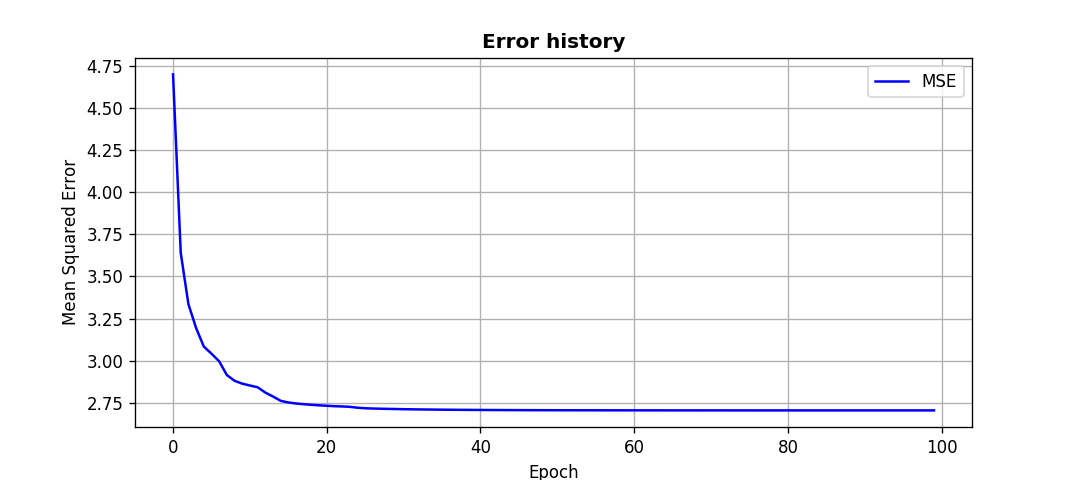

In [8]:
# First

data_loader = get_data_loaders(all_data, all_data, batch_size=1000, test_split=None)

ed_1 = EncoderDecoder_1()
optimizer = optim.Adam(ed_1.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist, test_loss_hist = [], []

for epoch in range(100):
    train_loss = train_reg(ed_1, data_loader, optimizer, epoch)
    test_loss = test_reg(ed_1, data_loader, epoch, log_freq=10)
    scheduler.step()
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    
# Plot of reconstruction error
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)
ax1.plot(test_loss_hist, color='blue', label='MSE')
ax1.set_title('Error history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error')
ax1.grid()
ax1.legend()
    
latent_1 = ed_1.get_encoded(all_data)

Test 0 : Average loss: 1.8990
Test 10 : Average loss: 0.9788
Test 20 : Average loss: 0.9784
Test 30 : Average loss: 0.9783
Test 40 : Average loss: 0.9782
Test 50 : Average loss: 0.9782
Test 60 : Average loss: 0.9782
Test 70 : Average loss: 0.9782
Test 80 : Average loss: 0.9782
Test 90 : Average loss: 0.9782


<IPython.core.display.Javascript object>


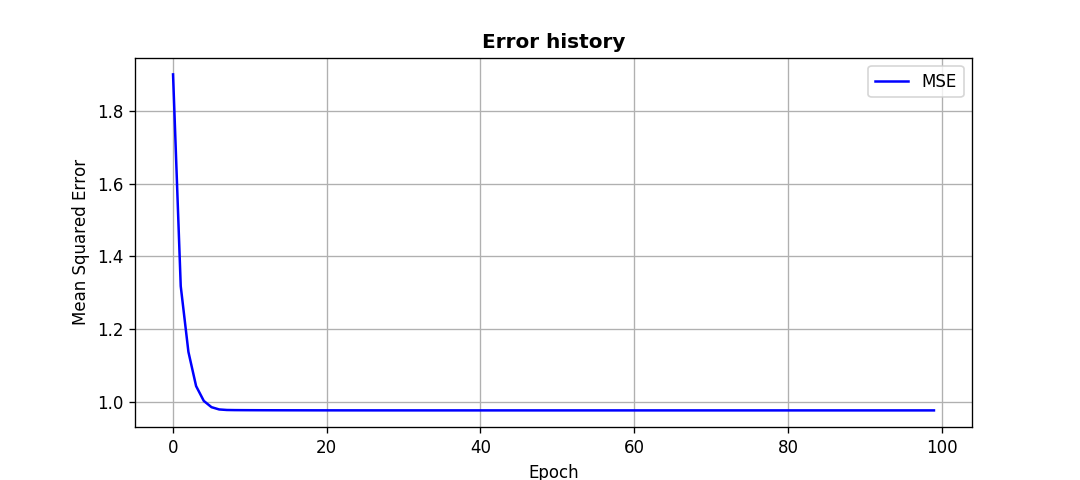

In [9]:
# Second

data_loader = get_data_loaders(latent_1, latent_1, batch_size=1000, test_split=None)

ed_2 = EncoderDecoder_2()
optimizer = optim.Adam(ed_2.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist, test_loss_hist = [], []

for epoch in range(100):
    train_loss = train_reg(ed_2, data_loader, optimizer, epoch)
    test_loss = test_reg(ed_2, data_loader, epoch, log_freq=10)
    scheduler.step()
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    
# Plot of reconstruction error
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)
ax1.plot(test_loss_hist, color='blue', label='MSE')
ax1.set_title('Error history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error')
ax1.grid()
ax1.legend()
    
latent_2 = ed_2.get_encoded(latent_1)

Test 0 : Average loss: 3.7550
Test 10 : Average loss: 2.4620
Test 20 : Average loss: 2.4551
Test 30 : Average loss: 2.3880
Test 40 : Average loss: 2.3852
Test 50 : Average loss: 2.3846
Test 60 : Average loss: 2.3844
Test 70 : Average loss: 2.3844
Test 80 : Average loss: 2.3843
Test 90 : Average loss: 2.3843


<IPython.core.display.Javascript object>


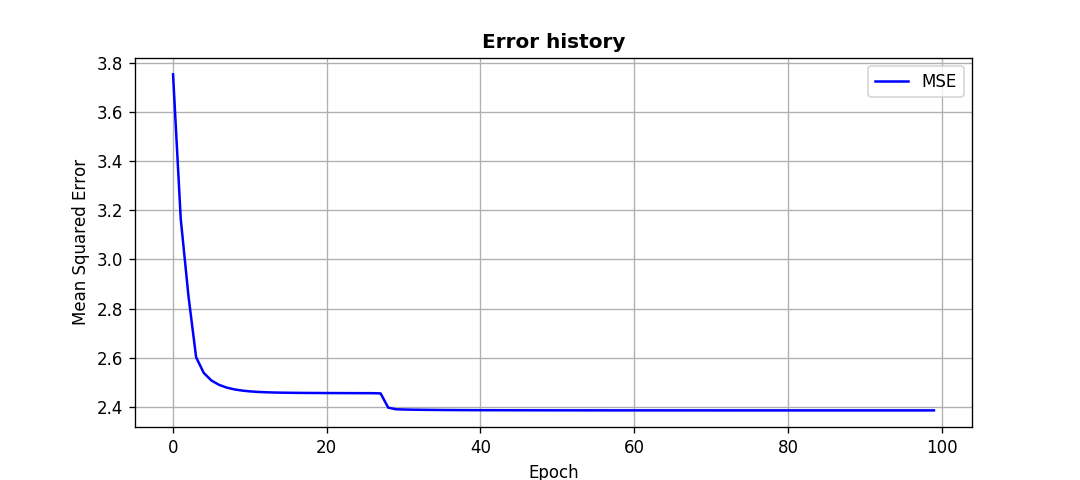

In [10]:
# Third

data_loader = get_data_loaders(latent_2, latent_2, batch_size=1000, test_split=None)

ed_3 = EncoderDecoder_3()
optimizer = optim.Adam(ed_3.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist, test_loss_hist = [], []

for epoch in range(100):
    train_loss = train_reg(ed_3, data_loader, optimizer, epoch)
    test_loss = test_reg(ed_3, data_loader, epoch, log_freq=10)
    scheduler.step()
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    
# Plot of reconstruction error
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)
ax1.plot(test_loss_hist, color='blue', label='MSE')
ax1.set_title('Error history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error')
ax1.grid()
ax1.legend()
    
latent_3 = ed_3.get_encoded(latent_2)

## Classification with stacked autoencoder
In this last section, we stack encoders from the above networks to form the autoencoder and append a classifier layer in the end to generate predictions. Then we will observe trends of loss and accuracy over epochs.

Test 0 : Average loss: 1.4210 	 Accuracy: 1900/6000 (31.67%)
Test 10 : Average loss: 0.8682 	 Accuracy: 3051/6000 (50.85%)
Test 20 : Average loss: 0.8416 	 Accuracy: 3022/6000 (50.37%)
Test 30 : Average loss: 0.8362 	 Accuracy: 3035/6000 (50.58%)
Test 40 : Average loss: 0.8312 	 Accuracy: 3119/6000 (51.98%)
Test 50 : Average loss: 0.8303 	 Accuracy: 3105/6000 (51.75%)
Test 60 : Average loss: 0.8298 	 Accuracy: 3107/6000 (51.78%)
Test 70 : Average loss: 0.8296 	 Accuracy: 3107/6000 (51.78%)
Test 80 : Average loss: 0.8295 	 Accuracy: 3107/6000 (51.78%)
Test 90 : Average loss: 0.8295 	 Accuracy: 3107/6000 (51.78%)



<IPython.core.display.Javascript object>


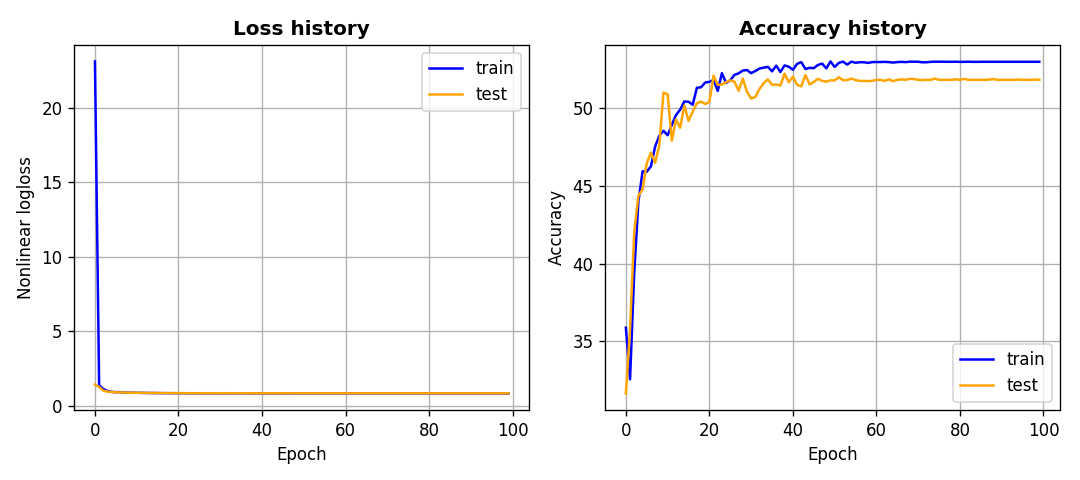

Final training loss: 0.8203
Final training accuracy: 52.9417
Final validation loss: 0.8295
Final validation accuracy: 51.7833


In [11]:
# Stack all encoder and predict

net = torch.nn.Sequential(
    ed_1.encoder,
    ed_2.encoder,
    ed_3.encoder,
    torch.nn.Linear(200, 5),
    torch.nn.LogSoftmax(dim=1)
)

# Data loaders for unreduced data
train_loader, test_loader = get_data_loaders(all_data, labels, test_split=0.2, batch_size=1000)

# Optimizer and learning rate scheduler
optimizer = optim.Adam(net.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist, test_loss_hist = [], []
train_accuracy_hist, test_accuracy_hist = [], []

for epoch in range(100):
    train_loss, train_accuracy = train_clf(net, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test_clf(net, test_loader, epoch, log_freq=10)
    scheduler.step()
    
    train_loss_hist.append(train_loss)
    train_accuracy_hist.append(train_accuracy)
    test_loss_hist.append(test_loss)
    test_accuracy_hist.append(test_accuracy)
    
print('')

# Plots of loss and accuracy
fig = plt.figure(figsize=(9, 4))

# Loss plots
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_hist, color='blue', label='train')
ax1.plot(test_loss_hist, color='orange', label='test')
ax1.set_title('Loss history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Nonlinear logloss')
ax1.grid()
ax1.legend()

# Accuracy plots
ax2 = fig.add_subplot(122)
ax2.plot(train_accuracy_hist, color='blue', label='train')
ax2.plot(test_accuracy_hist, color='orange', label='test')
ax2.set_title('Accuracy history', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

# Final training and validation accuracy
print("Final training loss: {:.4f}".format(train_loss_hist[-1]))
print("Final training accuracy: {:.4f}".format(train_accuracy_hist[-1]))
print("Final validation loss: {:.4f}".format(test_loss_hist[-1]))
print("Final validation accuracy: {:.4f}".format(test_accuracy_hist[-1]))

## Conclusions

Compared to the experiments in the previous task, the model has been able to perform much better here. The model reaches saturation surprisingly fast and the chances of overfitting are low, given that training and validation performance is very close. Thus, we can conclude that it has been beneficial to add one more encoder to the autoencoder stack.

Please also note that model convergence is not stable across runs, i.e. another run might not result in performance as good (or as bad) as this one.